# Neural & Behavioral Modeling - Week 11 (Exercises)
by 李采蓉 b08207042@ntu.edu.tw

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [2]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.12.1+cu113
No GPU


## 1 Fair Performance Evaluation (2 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (2 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [ ]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
train_set = CIFAR10(root='.', train=True, download=True, transform=transforms.ToTensor())
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_set = CIFAR10(root='.', train=False, download=True, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


### 1.1 The model

In [ ]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing
#### (1) run the section 1.2 TEN times

In [ ]:
testRes=[]
for run in range(10):
  # Training:
  for e in range(2):
      for i, (X_train, Y_train) in enumerate(train_data, 0):
          X_train,Y_train=X_train.to(device),Y_train.to(device)
          Y_pred = lenet(X_train)
          loss = loss_fn(Y_pred, Y_train)
          lenet.zero_grad()
          loss.backward()
          optimizer.step()   
          Y_pred = lenet(X_train)
          Y_pred = t.max(Y_pred,1)[1]
      # print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
      
  # Testing on a batch:
  dataiter = iter(test_data)
  X_test, Y_test = dataiter.next() # returning a batch
  X_test,Y_test=X_test.to(device),Y_test.to(device)
  with t.no_grad():
      Y_pred = lenet(X_test)
      Y_pred = t.max(Y_pred,1)[1]
      testRes.append((Y_pred==Y_test).sum().item()/Y_test.shape[0])

# report the testing accuracies
for acc in testRes:
  print(acc)

0.604  
0.638  
0.694  
0.676  
0.688  
0.715  
0.737  
0.743  
0.747  
0.742  


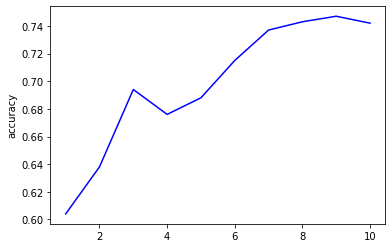

In [ ]:
plot([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], testRes, color='b')
ylabel('accuracy')
show()

In [ ]:
print('min:\t'+str(min(testRes))+'\nmax\t'+str(max(testRes))+'\nmean:\t'+str(sum(testRes)/10)+'\nstd:\t'+str(np.std(testRes))+'\n')

min:	0.604
max	0.747
mean:	0.6984
std:	0.046050407164323744



#### (2) fix the random number seeds

In [ ]:
import random

In [ ]:
for run in range(10):
  # set the seed
  seed = 1022
  t.manual_seed(seed)
  t.cuda.manual_seed(seed)
  t.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  t.backends.cudnn.benchmark = False
  t.backends.cudnn.deterministic = True

  lenet = Net()
  lenet = lenet.to(device)
  loss_fn = t.nn.CrossEntropyLoss()
  optimizer = t.optim.Adam(lenet.parameters())

  # Training:
  for e in range(2):
      for i, (X_train, Y_train) in enumerate(train_data, 0):
          X_train,Y_train=X_train.to(device),Y_train.to(device)
          Y_pred = lenet(X_train)
          loss = loss_fn(Y_pred, Y_train)
          lenet.zero_grad()
          loss.backward()
          optimizer.step()   
          Y_pred = lenet(X_train)
          Y_pred = t.max(Y_pred,1)[1]
      # print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
      
  # Testing on a batch:
  dataiter = iter(test_data)
  X_test, Y_test = dataiter.next() # returning a batch
  X_test,Y_test=X_test.to(device),Y_test.to(device)
  with t.no_grad():
      Y_pred = lenet(X_test)
      Y_pred = t.max(Y_pred,1)[1]
      print((Y_pred==Y_test).sum().item()/Y_test.shape[0])

0.501
0.501
0.501
0.501
0.501
0.501
0.501
0.501
0.501
0.501


### 1.3 Your answers

Please respond to the questions here.<br>
(1) <br>
min:	0.604<br>
max	0.747<br>
mean:	0.6984<br>
std:	0.046050407164323744<br>

(2) 要保證重複性，勢必要從seed的設定下手。假若沒有設定seed，系統會根據時間決定生成的隨機數，因此才會有rerun同個block但出來的結果也不同的情形；而有設定seed的話就能保證每次生成的隨機整數皆相同。除此之外還有一點要注意的是，seed的調用會延續到下一次定義seed的時候，所以seed的設定才會在迴圈以內而不是外面。<br>
延伸閱讀：[关于numpy,torch中seed()方法的一些理解](https://blog.csdn.net/F845992311/article/details/123553715)

## 2 Universal Approximation Theorem (4 points)

Please FAIRLY evaluate whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

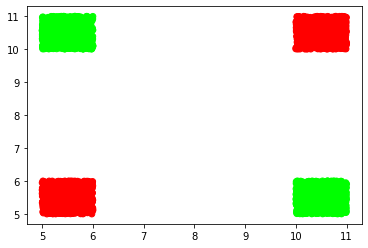

In [3]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [ ]:
# Number of free parameters: 2*H+H*2=48

H=12 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

epoch  0 : 0.25
epoch  1 : 0.25125
epoch  2 : 0.2575
epoch  3 : 0.26525
epoch  4 : 0.27875
epoch  5 : 0.30125
epoch  6 : 0.32575
epoch  7 : 0.3565
epoch  8 : 0.3875
epoch  9 : 0.4165
epoch  10 : 0.44075
epoch  11 : 0.46325
epoch  12 : 0.48075
epoch  13 : 0.49225
epoch  14 : 0.4995
epoch  15 : 0.5
epoch  16 : 0.5
epoch  17 : 0.5
epoch  18 : 0.5
epoch  19 : 0.5
epoch  20 : 0.5
epoch  21 : 0.5
epoch  22 : 0.5
epoch  23 : 0.5
epoch  24 : 0.5
epoch  25 : 0.5
epoch  26 : 0.5
epoch  27 : 0.5
epoch  28 : 0.5
epoch  29 : 0.5
epoch  30 : 0.5
epoch  31 : 0.5
epoch  32 : 0.5
epoch  33 : 0.5
epoch  34 : 0.5
epoch  35 : 0.5
epoch  36 : 0.5
epoch  37 : 0.5
epoch  38 : 0.5
epoch  39 : 0.5
epoch  40 : 0.5
epoch  41 : 0.5
epoch  42 : 0.5
epoch  43 : 0.5
epoch  44 : 0.5
epoch  45 : 0.5
epoch  46 : 0.5
epoch  47 : 0.5
epoch  48 : 0.5
epoch  49 : 0.5
epoch  50 : 0.5
epoch  51 : 0.5
epoch  52 : 0.5
epoch  53 : 0.5
epoch  54 : 0.5
epoch  55 : 0.5
epoch  56 : 0.5
epoch  57 : 0.5
epoch  58 : 0.5
epoch  59 : 0.

#### 2.2 A "deep" net with three hidden layers

In [5]:
# Number of free parameters: 2*H+H*H+H*H+H*2=48

H=4 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

epoch  0 : 0.49975
epoch  1 : 0.5
epoch  2 : 0.5
epoch  3 : 0.5
epoch  4 : 0.5
epoch  5 : 0.5
epoch  6 : 0.5
epoch  7 : 0.5
epoch  8 : 0.5
epoch  9 : 0.50225
epoch  10 : 0.5265
epoch  11 : 0.5585
epoch  12 : 0.5905
epoch  13 : 0.622
epoch  14 : 0.662
epoch  15 : 0.68975
epoch  16 : 0.71025
epoch  17 : 0.728
epoch  18 : 0.739
epoch  19 : 0.74425
epoch  20 : 0.748
epoch  21 : 0.74925
epoch  22 : 0.75
epoch  23 : 0.75
epoch  24 : 0.75
epoch  25 : 0.75
epoch  26 : 0.75
epoch  27 : 0.75
epoch  28 : 0.75
epoch  29 : 0.75
epoch  30 : 0.75
epoch  31 : 0.75
epoch  32 : 0.75
epoch  33 : 0.75
epoch  34 : 0.75
epoch  35 : 0.75
epoch  36 : 0.75
epoch  37 : 0.75
epoch  38 : 0.75
epoch  39 : 0.75
epoch  40 : 0.75
epoch  41 : 0.75
epoch  42 : 0.75
epoch  43 : 0.75025
epoch  44 : 0.75025
epoch  45 : 0.7525
epoch  46 : 0.75475
epoch  47 : 0.757
epoch  48 : 0.758
epoch  49 : 0.76175
epoch  50 : 0.764
epoch  51 : 0.766
epoch  52 : 0.77125
epoch  53 : 0.77475
epoch  54 : 0.7785
epoch  55 : 0.783
epoch  56 

### 2.3 Your answers

Please respond to the questions here.<br>
shallow model雖然淺，但他加入了十二個hidden layer，這大大的提升了模型處理非線性問題的能力；相反的，較深的模型加入的hidden layer較少，雖然說深度深同樣可以提升非線性處理能力，但目標對象比較是針對複雜特徵，也就是特徵數較多的情形，這裡僅有兩個特徵x和y，不需要太深的模型就可以處理。綜合而言，多hidden layer的模型在XOR的問題上會更有利、收斂得更快。<br>
延伸閱讀：[XOR Problem in Deep Neural Network](https://goodboychan.github.io/python/deep_learning/2020/09/16/01-XOR-Problem-in-Deep-Neural-Network.html)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;[前馈神经网络求解XOR问题](https://blog.csdn.net/mago2015/article/details/119141695)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;[【AI不惑境】网络深度对深度学习模型性能有什么影响？](https://zhuanlan.zhihu.com/p/63560913)